In [1]:
import contracts
contracts.disable_all()
import duckietown_world as dw
from duckietown_world.svg_drawing.ipython_utils import ipython_draw_html

INFO:dt-world:duckietown-world 1.0.15
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class Serializable
DEBUG:dt-serialization:Registering class GenericData
DEBUG:dt-serialization:Registering class Sequence
DEBUG:dt-serialization:Registering class SampledSequence
DEBUG:dt-serialization:Registering class Constant
DEBUG:dt-serialization:Registering class RectangularArea
DEBUG:dt-serialization:Registering class TransformSequence
DEBUG:dt-serialization:Registering class VariableTransformSequence
DEBUG:dt-serialization:Registering class SE2Transform
DEBUG:dt-serialization:Registering class Scale2D
DEBUG:dt-serialization:Registering class Matrix2D
DEBUG:dt-serialization:Registering class SpatialRelation
DEBUG:dt-serialization:Registering class GroundTruth
DEBUG:dt-serialization:Registering class PlacedObject
DEBUG:dt-serialization:Registering class EvaluatedMetric
DEBUG:dt-serialization:Registering class GenericObject
DEBUG:dt-serialization:Registeri

In [2]:
dw.logger.setLevel(50)

In [3]:
%%html
<style>
pre {line-height: 90%}
</style>

In [4]:
m = dw.load_map('4way')
ipython_draw_html(m);

In [5]:
sk = dw.get_skeleton_graph(m)

In [6]:
ipython_draw_html(sk.root2);

In [7]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=edge_labels,font_color='red')
    plt.axis('off')
    plt.show()

In [8]:
%matplotlib inline

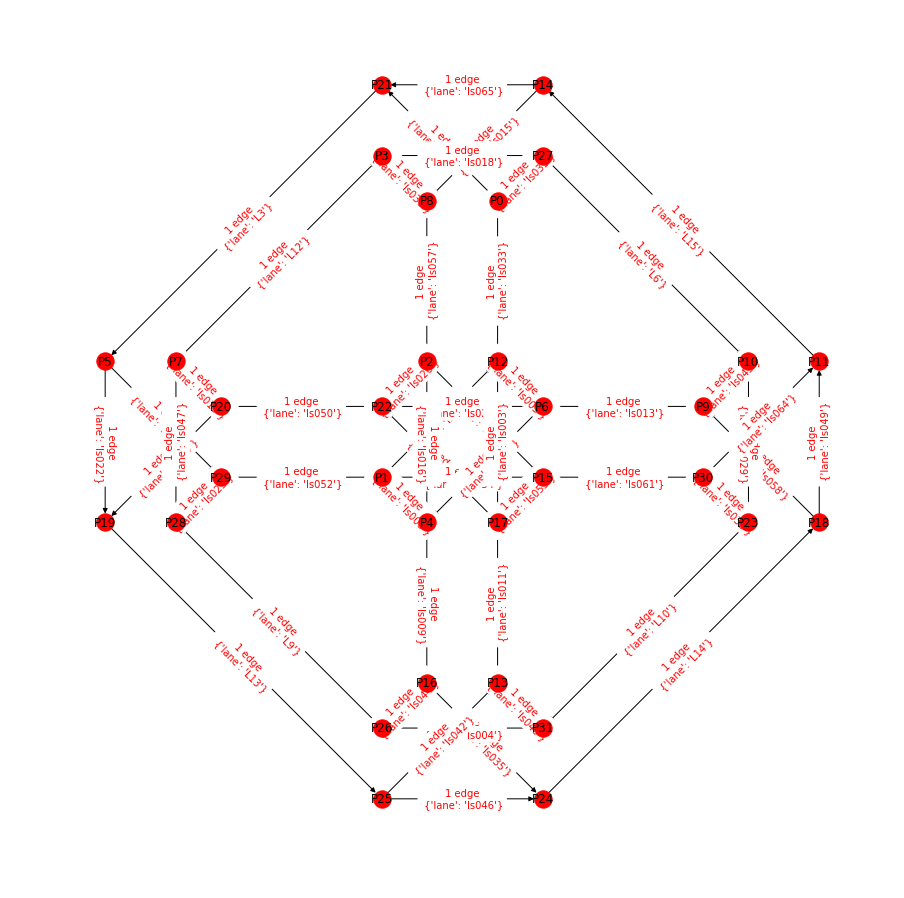

In [9]:
import geometry as geo
pos = {}
for n in sk.G:
    q = sk.G.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(sk.G, pos=pos)

# GET ALL LANE SEGMENTS IN THE MAP

In [10]:
from duckietown_world.world_duckietown.lane_segment import LaneSegment
"""
WRITE DOCSTRING HERE
"""
def get_lanes(parent, parent_name, obj, obj_name, result):
    if isinstance(obj, LaneSegment):
        result[(parent_name, obj_name)] = (parent, obj, parent.spatial_relations[obj_name].transform)
    for child_name, child in obj.children.items():
        get_lanes(obj, obj_name, child, child_name, result)
    return

In [11]:
extracted_lanes = dict()
get_lanes(None, '', m, '', extracted_lanes)

# ADD MORE CONTROL POINTS

In [12]:
from duckietown_world.utils import memoized_reset, SE2_interpolate, SE2_apply_R2
from duckietown_world.geo import SE2Transform, PlacedObject
import numpy as np
import geometry as geo
import copy

def middle_control_point(lane_segment_copy, beta, n_sublanes=0):
    n = len(lane_segment_copy.control_points)
    i = int(np.floor(beta))
    cp_new = []
    if i < 0:
        q0 = lane_segment_copy.control_points[0].asmatrix2d().m
        q1 = geo.SE2.multiply(q0, geo.SE2_from_translation_angle([0.1, 0], 0))
        alpha = beta

    elif i >= n - 1:
        # q0 = self.control_points[-2].asmatrix2d().m
        q0 = lane_segment_copy.control_points[-1].asmatrix2d().m
        q1 = geo.SE2.multiply(q0, geo.SE2_from_translation_angle([0.1, 0], 0))
        alpha = beta - (n - 1)
    else:
        alpha = beta - i
        q0 = lane_segment_copy.control_points[i].asmatrix2d().m
        q1 = lane_segment_copy.control_points[i + 1].asmatrix2d().m
        
    q = SE2_interpolate(q0, q1, alpha)
    p, theta = geo.translation_angle_from_SE2(q)
    cp_new.append(SE2Transform(p, theta))  
    
    width = lane_segment_copy.width / 2

    for i in list(reversed(range(n_sublanes + 1)[1:])):
        w = i * width / n_sublanes
        
        q_right = geo.SE2.multiply(q, geo.SE2_from_translation_angle([0, w], 0))
        p, theta = geo.translation_angle_from_SE2(q_right)
        cp_new.append(SE2Transform(p, theta))
        
        q_left = geo.SE2.multiply(q, geo.SE2_from_translation_angle([0, -w], 0))
        p, theta = geo.translation_angle_from_SE2(q_left)
        cp_new.append(SE2Transform(p, theta))
        
    return cp_new

def add_control_points(lane_segment_copy, points_per_segment=3):
    lane_copy = copy.deepcopy(lane_segment_copy)
    n = len(lane_copy.control_points) - 1
    num = n * points_per_segment
    betas = np.linspace(0, n, num=num)
    res = []
    for beta in betas:
        cp_new = middle_control_point(lane_copy, beta)
        res += cp_new
    lane_copy.control_points = res
    return lane_copy

def get_more_points(lane_segment_copy, points_per_segment=3, n_sublanes=0):


    points_left_right = []

    n = len(lane_segment_copy.control_points) - 1
    num = n * points_per_segment
    betas = np.linspace(0, n, num=num)
    width = self.width / 2

    for i in list(reversed(range(n_sublanes + 1))):  # range(n_sublanes + 1)[1:] if without the center-lane

        points_left = []
        points_right = []
        w = i * width / n_sublanes

        for beta in betas:

            q = lane_segment_copy.center_point(beta)
            delta_left = np.array([0, w])
            delta_right = np.array([0, -w])
            points_left.append(SE2_apply_R2(q, delta_left))
            points_right.append(SE2_apply_R2(q, delta_right))

        # points_left_right.append(points_right)
        # points_left_right.append(reversed(points_left))

        points_left_right += points_right + list(reversed(points_left))


    print(len(list(points_left_right)))

    return points_left_right

# ADD MORE VIRTUAL LANES

In [13]:
import geometry as geo
"""
WRITE DOCSTRING HERE
"""
def shift_points(lane, p, theta):
    for i, cp in enumerate(lane.control_points):
        relative_transform = geo.SE2_from_translation_angle(p, theta)
        transform = geo.SE2.multiply(cp.as_SE2(), relative_transform)
        lane.control_points[i] = SE2Transform.from_SE2(transform)

In [14]:
import copy
from duckietown_world.geo.transforms import SE2Transform

"""
MISSING: Paramterize the num of virtual lanes
right now adds only a right lane and a left lane
ADDS VIRTUAL LANES IN PLACE
"""
def add_virtual_lanes(extracted_lanes, num_of_virtual_lanes_per_real_lane=3):
    i = 0
    for key, tile_lane in extracted_lanes.items():
        tile, lane, spatil_relation = tile_lane
        temp_lane_old = copy.deepcopy(lane)
        tile.remove_object(key[1])
        old_width = temp_lane_old.width
        temp_lane_old.width = temp_lane_old.width / float(num_of_virtual_lanes_per_real_lane)
#         print("changing width lane from ", old_width, " to ", temp_lane_old.width)
        temp_lane_old = add_control_points(temp_lane_old)
#         ipython_draw_html(copy);
        tile.set_object(key[1], temp_lane_old, ground_truth=spatil_relation)
        i = i + 1
#         print("Modifying Lane Segment Number ", i, " with name ", key)
        #create new left lanes
        temp_lane_new_left = copy.deepcopy(lane)
        temp_lane_new_left.width = temp_lane_new_left.width / float(num_of_virtual_lanes_per_real_lane)        
        #SE2 Transform for left lane
    #         spatil_relation.p = spatil_relation.p + [0, -temp_lane_new_left.width]
    #         temp_transform = SE2Transform(p=[0, -temp_lane_new_left.width], theta=0)
        shift_points(temp_lane_new_left, [0, -temp_lane_new_left.width], 0)
        temp_lane_new_left = add_control_points(temp_lane_new_left)
        tile.set_object('temp_lane_l_'+str(i), temp_lane_new_left, ground_truth=spatil_relation)
        #create new right lanes
        temp_lane_new_right = copy.deepcopy(lane)
        temp_lane_new_right.width = temp_lane_new_right.width / float(num_of_virtual_lanes_per_real_lane)        
        shift_points(temp_lane_new_right, [0, temp_lane_new_left.width], 0)
        temp_lane_new_right = add_control_points(temp_lane_new_right)
        tile.set_object('temp_lane_r_'+str(i), temp_lane_new_right, ground_truth=spatil_relation)

In [15]:
add_virtual_lanes(extracted_lanes, num_of_virtual_lanes_per_real_lane=3)

In [16]:
print(dw.get_object_tree(m, levels=12))

DuckietownMap

├ ob00-trafficlight ┐ TrafficLight
│                   └───────────────
└ tilemap ┐ TileMap
          │ 
          │ ├ tile-0-4 ┐ Tile
          │ │          │
          │ │          │ └ curve_left ┐ PlacedObject
          │ │          │              │
          │ │          │              │ └ curve ┐ PlacedObject
          │ │          │              │         │
          │ │          │              │         │ ├ temp_lane_r_4 ┐ LaneSegment
          │ │          │              │         │ │               └──────────────
          │ │          │              │         │ ├ lane2 ┐ LaneSegment
          │ │          │              │         │ │       └──────────────
          │ │          │              │         │ ├ lane1 ┐ LaneSegment
          │ │          │              │         │ │       └──────────────
          │ │          │              │         │ ├ temp_lane_l_21 ┐ LaneSegment
          │ │          │              │         │ │                └──────────────
 

# Virtualize the map with virtual Lanes now

In [17]:
ipython_draw_html(m);

In [18]:
sk = dw.get_skeleton_graph(m)

Exception: Completeness assumption violated at point (0.49, 1.75, 0.0, 1.0): MP(0 1 | set([]), set(['ls020']))

In [ ]:
ipython_draw_html(sk.root2);

In [ ]:
type(sk.root2)

In [ ]:
def draw_graph(G0, pos=None):
    import networkx as nx
    from matplotlib import pyplot as plt
    pos = pos or nx.spring_layout(G0)
    plt.figure(figsize=(12, 12))    
    nx.draw(G0,pos,labels={node:node for node in G0.nodes()})
    def edge_label(a, b):
        datas = G0.get_edge_data(a, b)
        s = '%d edge%s' % (len(datas), 's' if len(datas)>=2 else '')
        for k, v in datas.items():
            if v:
                if 'label' in v:
                    s += '\n %s' % v['label']
                else:
                    s += '\n %s' %v
        return s
    edge_labels = dict([ ((a,b), edge_label(a,b)) for a,b in G0.edges()])
    nx.draw_networkx_edge_labels(G0,pos,edge_labels=edge_labels,font_color='red')
    plt.axis('off')
    plt.show()

In [ ]:
%matplotlib inline

In [ ]:
import geometry as geo
pos = {}
for n in sk.G:
    q = sk.G.nodes[n]['point'].as_SE2()
    t, _ = geo.translation_angle_from_SE2(q)
    pos[n] = t
draw_graph(sk.G, pos=pos)

In [ ]:
pos

# Get Number of Control Points

In [ ]:
def get_number_of_control_points(obj):
    if isinstance(obj, LaneSegment):
        return len(obj.control_points)
    num_of_control_points = 0
    for child_name, child in obj.children.items():
        num_of_control_points = num_of_control_points + get_number_of_control_points(child)
    return num_of_control_points

In [ ]:
get_number_of_control_points(m)

In [ ]:
len(sk.G)